<a href="https://colab.research.google.com/github/Hassan6678/Machine-Learning/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers -q
!pip install datasets -q

In [17]:
from datasets import list_datasets, load_dataset
import pandas as pd

In [8]:
all_datasets = list_datasets()
len(all_datasets),all_datasets[:10]

(44067,
 ['acronym_identification',
  'ade_corpus_v2',
  'adversarial_qa',
  'aeslc',
  'afrikaans_ner_corpus',
  'ag_news',
  'ai2_arc',
  'air_dialogue',
  'ajgt_twitter_ar',
  'allegro_reviews'])

In [11]:
emotions = load_dataset('emotion')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [13]:
train_ds = emotions['train']

In [15]:
train_ds[10]

{'text': 'i feel like i have to make the suffering i m seeing mean something',
 'label': 0}

In [16]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [18]:
emotions.set_format(type="pandas")

In [20]:
df = emotions['train'][:]
df.sample(5)

,text,label
14571,i think the whimsical pop art feel of the plac...,1
8193,i still get excellent feedback from unlikely p...,1
2701,i pulled myself off the blanket and bed was re...,0
15313,i kept feeling like i missed something and i n...,0
13496,i would save it for the next time im feeling c...,3


In [21]:
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


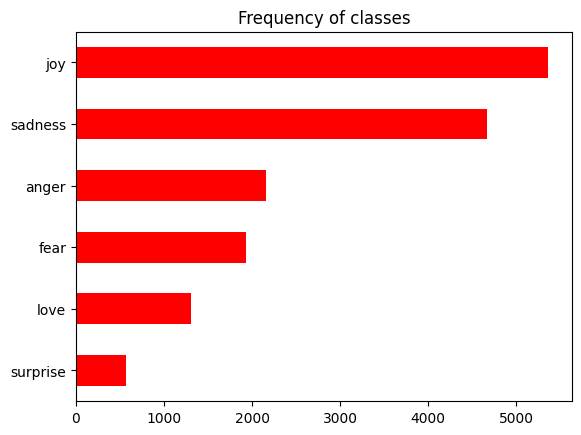

In [26]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh(color='red')
plt.title("Frequency of classes")
plt.show()